<a href="https://colab.research.google.com/github/Sidarth-V/NLP-Project/blob/main/Parallel_Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Package imports
import keras
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import Input, Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Concatenate, Activation, Dropout, Flatten, Dense
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [ ]:
# Importing dataset from drive for independence from runtime
from google.colab import drive
drive.mount('/content/drive')

# Loading dataset
data = np.load('drive/My Drive/ORL_faces.npz')

# Load the train images
x_train = data['trainX']

# Normalize every image
x_train = np.array(x_train,dtype='float32')/255

x_test = data['testX']
x_test = np.array(x_test,dtype='float32')/255

# Load the label of images
y_train= data['trainY']
y_test= data['testY']

# Show the train and test data format
print('x_train : {}'.format(x_train[:]))
print('Y-train shape: {}'.format(y_train))
print('x_test shape: {}'.format(x_test.shape))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
x_train : [[0.1882353  0.19215687 0.1764706  ... 0.18431373 0.18039216 0.18039216]
 [0.23529412 0.23529412 0.24313726 ... 0.1254902  0.13333334 0.13333334]
 [0.15294118 0.17254902 0.20784314 ... 0.11372549 0.10196079 0.11372549]
 ...
 [0.44705883 0.45882353 0.44705883 ... 0.38431373 0.3764706  0.38431373]
 [0.4117647  0.4117647  0.41960785 ... 0.21176471 0.18431373 0.16078432]
 [0.45490196 0.44705883 0.45882353 ... 0.37254903 0.39215687 0.39607844]]
Y-train shape: [ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
 10 10 10 10 10 10 10 10 10 10 10 10 

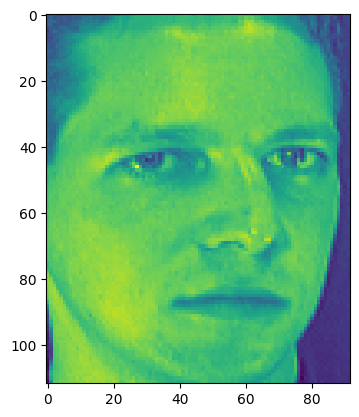

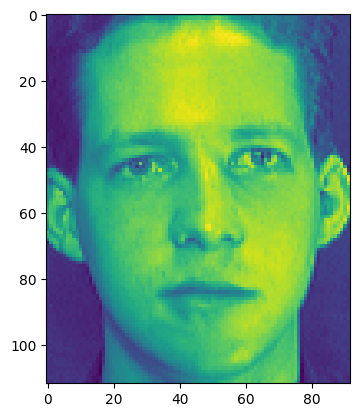

In [ ]:
# setting global values of image shapes
im_rows = 112
im_cols = 92
batch_size = 512
im_shape=(im_rows, im_cols, 1)


# To see sample images in Train and Test data
c = x_train[1].reshape(im_rows, im_cols)
plt.imshow(c)

plt.show()

d = x_test[1].reshape(im_rows, im_cols)
plt.imshow(d)

In [ ]:
# 80 - 20 split of training and validation data
x_train, x_valid, y_train, y_valid= train_test_split(x_train, y_train, test_size=.20, random_state=42,)

In [ ]:
#change the size of images
x_train = x_train.reshape(x_train.shape[0], *im_shape)
x_test = x_test.reshape(x_test.shape[0], *im_shape)
x_valid = x_valid.reshape(x_valid.shape[0], *im_shape)

print('x_train shape: {}'.format(y_train.shape[0]))
print('x_test shape: {}'.format(y_test.shape[0]))

x_train shape: 192
x_test shape: 160


In [ ]:
def seq_create_convnet(img_path='network_image.png'):
  # setting shape of input image
  input_shape = Input(shape = im_shape)

  # Conv1
  conv1 = Conv2D(20, (100, 5), padding='same', activation='relu')(input_shape)
  # MaxPool
  maxp1 = MaxPooling2D((1, 6), strides=(1, 1), padding='same')(conv1)

  # Conv2
  conv2 = Conv2D(20, (100, 7), padding='same', activation='relu')(maxp1)
  # MaxPool
  maxp2 = MaxPooling2D((1, 6), strides=(1, 1), padding='same')(conv2)

  # Conv3
  conv3 = Conv2D(20, (100, 10), padding='same', activation='relu')(maxp2)
  # MaxPool
  maxp3 = MaxPooling2D((1, 6), strides=(1, 1), padding='same')(conv3)

  # fusion layer 1
  fusion_layer = Flatten()(maxp3)

  dense_layer = Dense(200, activation='relu')(fusion_layer)
  output_layer = Dense(200, activation='softmax')(dense_layer)

  model = Model(input_shape, output_layer)
  plot_model(model, to_file = img_path)

  return model

In [ ]:
# creating sequential network by calling function
seq_model = seq_create_convnet()

# compiling neural netowk
seq_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy'],
)

# printing neural network diagram
seq_model.summary()
from IPython.display import Image
Image(retina=True, filename='network_image.png')

In [ ]:
# traning sequential network
seq_start_time = time.time()

seq_history=seq_model.fit(
    np.array(x_train), 
    np.array(y_train), batch_size=512,
    epochs=10, 
    verbose=2,
    validation_data=(np.array(x_valid),np.array(y_valid)),
)

seq_end_time = time.time()

seq_y_pred = seq_model.predict(x_test)

In [ ]:
# Calculate accuracy, F1 score, and speedup
accuracy = seq_model.evaluate(x_test, y_test)[1]
f1_sc = f1_score(y_test, np.argmax(seq_y_pred, axis=1), average='macro')
seq_training_time = seq_end_time - seq_start_time

# Print the results
print('Accuracy:', accuracy)
print('F1 score:', f1_sc)
print('Training time sequential:', seq_training_time)

In [ ]:
# summarize history for accuracy
plt.plot(seq_history.history['accuracy'])
plt.plot(seq_history.history['val_accuracy'])
plt.title('sequential model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(seq_history.history['loss'])
plt.plot(seq_history.history['val_loss'])
plt.title('sequential model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def mpd_create_convnet(img_path = 'network_image.png', filters = 16, kernel_size = 7, pool_size = 4, dropout_rate = 0.5):
  # setting shape of input image
  input_shape = Input(shape = im_shape)

  '''
  Tower 1
  '''
  # Conv1
  tower_1 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(input_shape)
  # Conv2
  tower_1 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(tower_1)
  # MaxPool
  tower_1 = MaxPooling2D((pool_size, pool_size), strides=(1, 1), padding='same')(tower_1)
  # Drouput
  # tower_1 = Dropout(dropout_rate, tower_1)

  # Conv3
  tower_1 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(tower_1)
  # Conv4
  tower_1 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(tower_1)
  # MaxPool
  tower_1 = MaxPooling2D((pool_size, pool_size), strides=(1, 1), padding='same')(tower_1)
  # Dropout
  # tower_1 = Dropout(dropout_rate, tower_1)

  # Conv5
  tower_1 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(tower_1)
  # Conv6
  tower_1 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(tower_1)
  # MaxPool
  tower_1 = MaxPooling2D((pool_size, pool_size), strides=(1, 1), padding='same')(tower_1)
  # Dropout
  # tower_1 = Dropout(dropout_rate, tower_1)

  '''
  Tower 2
  '''
  # Conv1
  tower_2 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(input_shape)
  # Conv2
  tower_2 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(tower_2)
  # MaxPool
  tower_2 = MaxPooling2D((pool_size, pool_size), strides=(1, 1), padding='same')(tower_2)
  # Dropout
  # tower_2 = Dropout(dropout_rate, tower_2)

  # Conv3
  tower_2 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(tower_2)
  # Conv4
  tower_2 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(tower_2)
  # MaxPool
  tower_2 = MaxPooling2D((pool_size, pool_size), strides=(1, 1), padding='same')(tower_2)
  # Dropout
  # tower_2 = Dropout(dropout_rate, tower_2)

  # MaxPool
  tower_2 = MaxPooling2D((pool_size, pool_size), strides=(1, 1), padding='same')(tower_2)
  # Dropout
  # tower_2 = Dropout(dropout_rate, tower_2)

  '''
  Tower 3
  '''
  # Conv1
  tower_3 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(input_shape)
  # MaxPool
  tower_3 = MaxPooling2D((pool_size, pool_size), strides=(1, 1), padding='same')(tower_3)
  # Dropout
  # tower_3 = Dropout(dropout_rate, tower_3)

  # MaxPool
  tower_3 = MaxPooling2D((pool_size, pool_size), strides=(1, 1), padding='same')(tower_3)
  # Dropout
  # tower_3 = Dropout(dropout_rate, tower_3)

  # MaxPool
  tower_3 = MaxPooling2D((pool_size, pool_size), strides=(1, 1), padding='same')(tower_3)
  # Dropout
  # tower_3 = Dropout(dropout_rate, tower_3)


  # fusion layer 1
  fusion_layer_1 = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)


  '''
  Tower 4
  '''
  # Conv1
  tower_4 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(fusion_layer_1)
  # Conv2
  tower_4 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(tower_4)
  # MaxPool
  tower_4 = MaxPooling2D((pool_size, pool_size), strides=(1, 1), padding='same')(tower_4)
  # Drouput
  # tower_4 = Dropout(dropout_rate, tower_4)

  # Conv3
  tower_4 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(tower_4)
  # Conv4
  tower_4 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(tower_4)
  # MaxPool
  tower_4 = MaxPooling2D((pool_size, pool_size), strides=(1, 1), padding='same')(tower_4)
  # Dropout
  # tower_4 = Dropout(dropout_rate, tower_4)

  # Conv5
  tower_4 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(tower_4)
  # Conv6
  tower_4 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(tower_4)
  # MaxPool
  tower_4 = MaxPooling2D((pool_size, pool_size), strides=(1, 1), padding='same')(tower_4)
  # Dropout
  # tower_4 = Dropout(dropout_rate, tower_4)

  '''
  Tower 5
  '''
  # Conv1
  tower_5 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(fusion_layer_1)
  # Conv2
  tower_5 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(tower_5)
  # MaxPool
  tower_5 = MaxPooling2D((pool_size, pool_size), strides=(1, 1), padding='same')(tower_5)
  # Dropout
  # tower_5 = Dropout(dropout_rate, tower_5)

  # Conv3
  tower_5 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(tower_5)
  # Conv4
  tower_5 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(tower_5)
  # MaxPool
  tower_5 = MaxPooling2D((pool_size, pool_size), strides=(1, 1), padding='same')(tower_5)
  # Dropout
  # tower_5 = Dropout(dropout_rate, tower_5)

  # MaxPool
  tower_5 = MaxPooling2D((pool_size, pool_size), strides=(1, 1), padding='same')(tower_5)
  # Dropout
  # tower_5 = Dropout(dropout_rate, tower_5)

  '''
  Tower 6
  '''
  # Conv1
  tower_6 = Conv2D(filters, (kernel_size, kernel_size), padding='same', activation='relu')(fusion_layer_1)
  # MaxPool
  tower_6 = MaxPooling2D((pool_size, pool_size), strides=(1, 1), padding='same')(tower_6)
  # Dropout
  # tower_6 = Dropout(dropout_rate, tower_6)

  # MaxPool
  tower_6 = MaxPooling2D((pool_size, pool_size), strides=(1, 1), padding='same')(tower_6)
  # Dropout
  # tower_6 = Dropout(dropout_rate, tower_6)

  # MaxPool
  tower_6 = MaxPooling2D((pool_size, pool_size), strides=(1, 1), padding='same')(tower_6)
  # Dropout
  # tower_6 = Dropout(dropout_rate, tower_6)

  # fusion layer 1
  fusion_layer_2 = keras.layers.concatenate([tower_4, tower_5, tower_6], axis=1)

  # flatter layer
  flatten_layer = Flatten()(fusion_layer_2)

  # dense layer
  dense_layer = Dense(200, activation='relu')(flatten_layer)

  # output layer
  output_layer = Dense(200, activation='softmax')(dense_layer)

  # final model
  model = Model(input_shape, output_layer)
  plot_model(model, to_file=img_path)

  return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 92, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 112, 92, 16)  800         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 112, 92, 16)  12560       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 112, 92, 16)  0           ['conv2d_1[0][0]']           

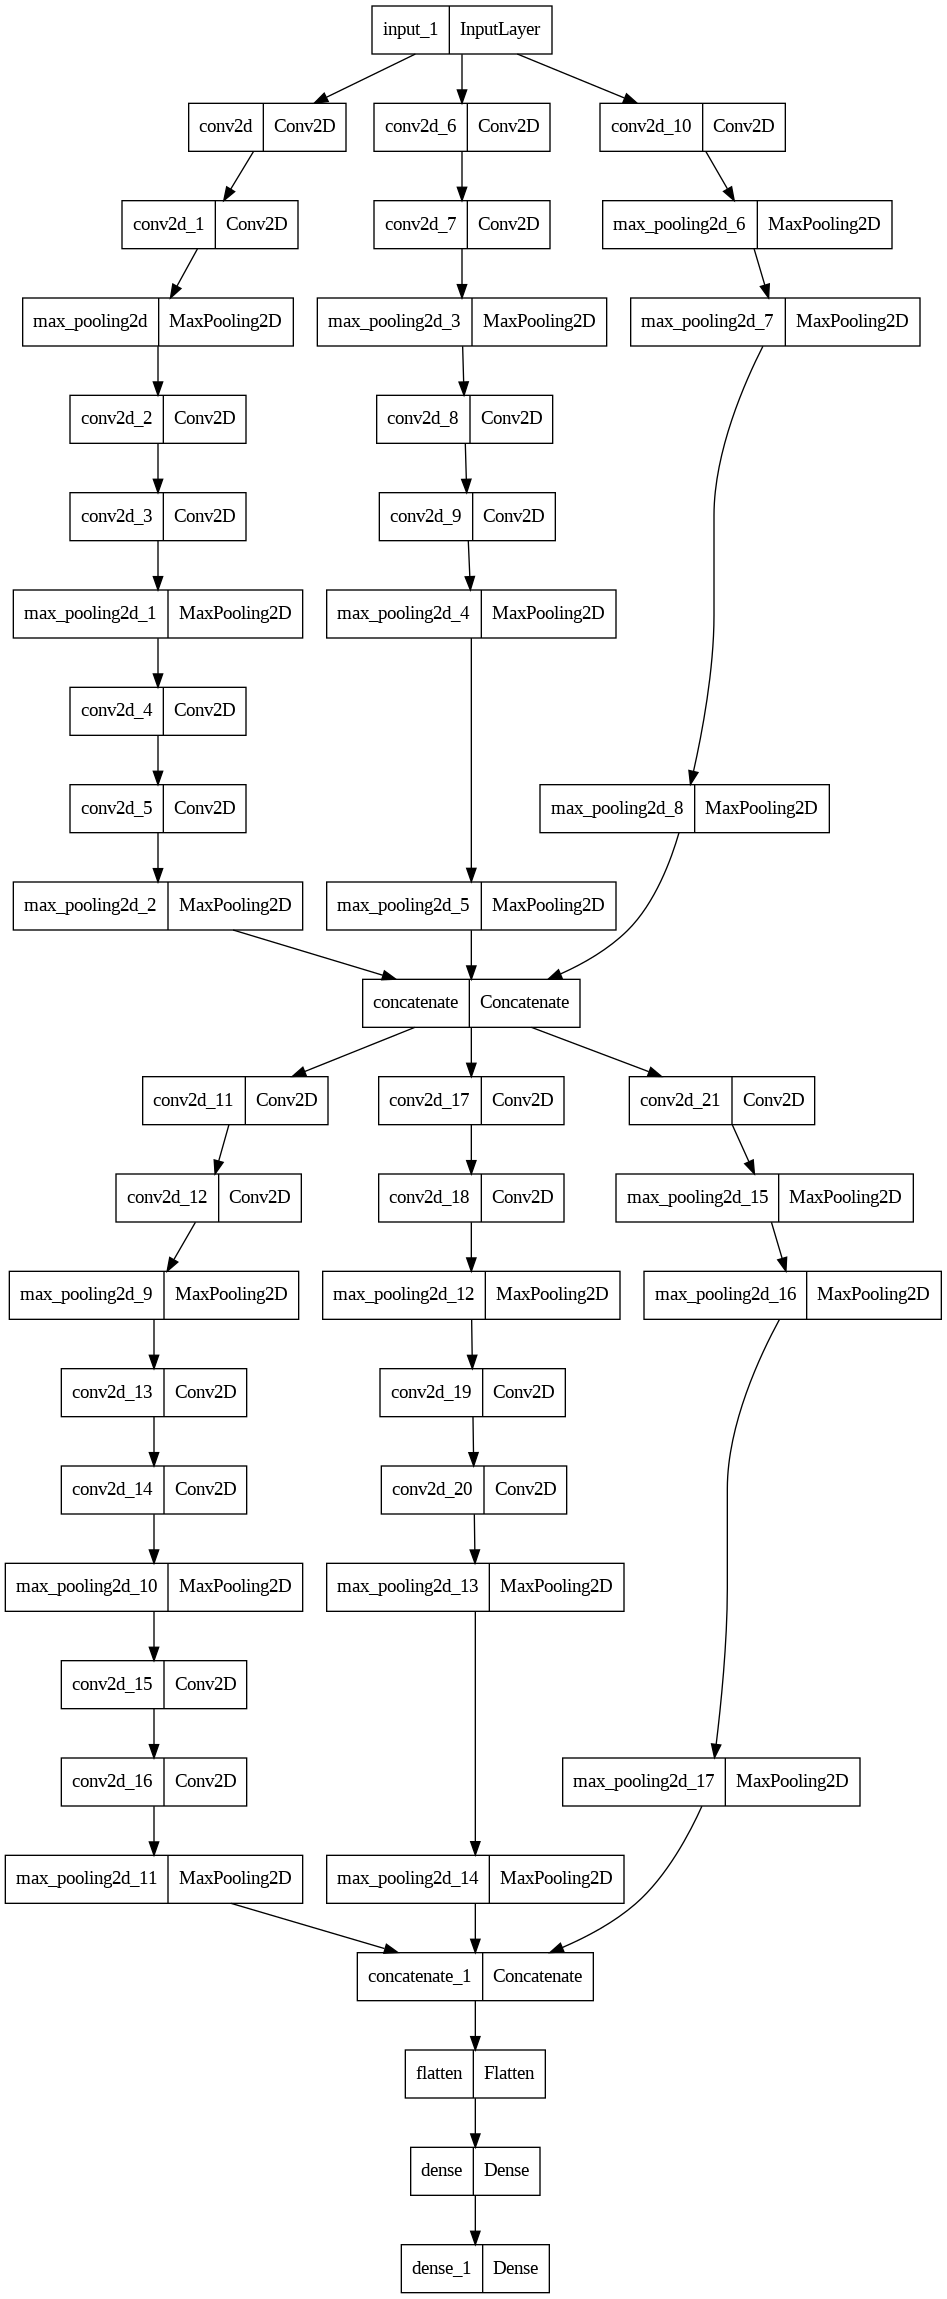

In [ ]:
# creating mpdCNN by calling function
mpd_cnn_model = mpd_create_convnet()

# compiling model
mpd_cnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# printing the netural network diagram
mpd_cnn_model.summary()
from IPython.display import Image
Image(retina=True, filename='network_image.png')

In [ ]:
# training of neural network
start_time = time.time()

history=mpd_cnn_model.fit(
    np.array(x_train), np.array(y_train), 
    batch_size=16,
    epochs=20, 
    verbose=2,
    validation_data=(np.array(x_valid),np.array(y_valid))
)

end_time = time.time()

y_pred = mpd_cnn_model.predict(x_test)

Epoch 1/20
12/12 - 8s - loss: 4.5677 - accuracy: 0.0625 - val_loss: 4.3306 - val_accuracy: 0.0833 - 8s/epoch - 700ms/step
Epoch 2/20
12/12 - 4s - loss: 3.7235 - accuracy: 0.1146 - val_loss: 3.2466 - val_accuracy: 0.1667 - 4s/epoch - 323ms/step
Epoch 3/20
12/12 - 4s - loss: 2.8287 - accuracy: 0.2656 - val_loss: 2.2875 - val_accuracy: 0.2917 - 4s/epoch - 324ms/step
Epoch 4/20
12/12 - 4s - loss: 1.8331 - accuracy: 0.5208 - val_loss: 1.3857 - val_accuracy: 0.7083 - 4s/epoch - 316ms/step
Epoch 5/20
12/12 - 4s - loss: 0.9035 - accuracy: 0.7708 - val_loss: 1.0350 - val_accuracy: 0.7708 - 4s/epoch - 336ms/step
Epoch 6/20
12/12 - 4s - loss: 0.3651 - accuracy: 0.9271 - val_loss: 0.1876 - val_accuracy: 0.9792 - 4s/epoch - 348ms/step
Epoch 7/20
12/12 - 4s - loss: 0.0786 - accuracy: 0.9948 - val_loss: 0.0795 - val_accuracy: 1.0000 - 4s/epoch - 335ms/step
Epoch 8/20
12/12 - 4s - loss: 0.0244 - accuracy: 1.0000 - val_loss: 0.1651 - val_accuracy: 0.9167 - 4s/epoch - 337ms/step
Epoch 9/20
12/12 - 4s - 

In [ ]:
# Calculate accuracy, F1 score, and speedup
accuracy = mpd_cnn_model.evaluate(x_test, y_test)[1]
f1_sc = f1_score(y_test, np.argmax(y_pred, axis=1), average='macro')
training_time_par = end_time - start_time
seq_training_time = 905
speedup = seq_training_time / training_time_par

# Print the results
print('Accuracy:', accuracy)
print('F1 score:', f1_sc)
print('Training time sequential:', seq_training_time)
print('Training time parallel:', training_time_par)
print('Speedup:', speedup)

5/5 [==============================] - 1s 109ms/step - loss: 0.2045 - accuracy: 0.9625
Accuracy: 0.9624999761581421
F1 score: 0.963015873015873
Training time sequential: 905
Training time parallel: 143.5028600692749
Speedup: 6.306494515601419


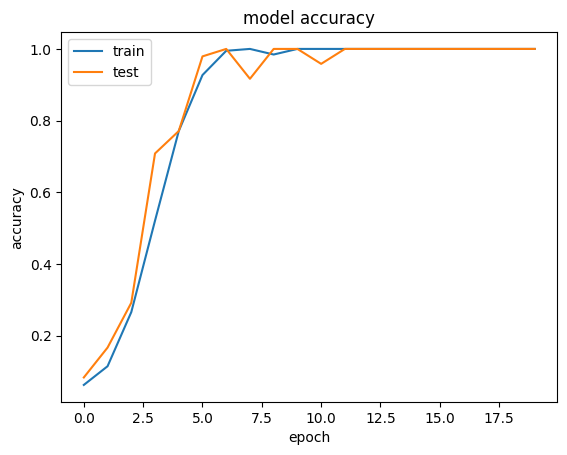

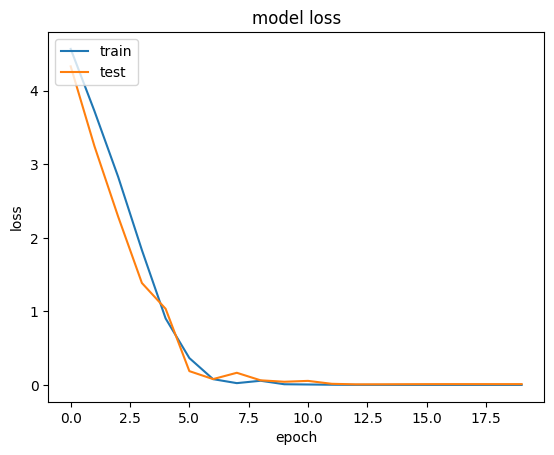

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()